In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import nltk
import unicodedata
import re
import env
import prepare
from matplotlib import style
style.use("ggplot")
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings("ignore")
from collections import Counter

In [2]:
#make df from data.json
df = pd.read_json('data.json')
df.head()

,repo,language,readme_contents
0,mcastrolab/Brazil-Covid19-e0-change,R,# Reduction in life expectancy in Brazil after...
1,jschoeley/de0anim,R,# Animated annual changes in life-expectancy\n...
2,sychi77/Thoracic_Surgery_Patient_Survival,Jupyter Notebook,# Thoracic Surgery for Lung Cancer Data Set\n ...
3,ashtad63/HackerRank-Data-Scientist-Hiring-Test,Jupyter Notebook,# HackerRank Data Scientist Hiring Test: Predi...
4,OxfordDemSci/ex2020,R,"<p align=""center"">\n <img src=""https://github..."


In [3]:
# how many rows  have readme_contents with length == 0
df[df['readme_contents'].str.len() == 0].language.value_counts()


Jupyter Notebook    10
R                    5
Stata                3
HTML                 2
Python               1
Objective-C          1
Scheme               1
Name: language, dtype: int64

In [4]:
df["no_readme_contents"] = df["readme_contents"].str.len()==0
# person of language with no readme_contents
df.groupby("language")["no_readme_contents"].mean().sort_values(ascending=False)

language
Objective-C         1.000000
Scheme              1.000000
Stata               0.600000
Jupyter Notebook    0.208333
R                   0.161290
HTML                0.090909
Python              0.052632
Dart                0.000000
Java                0.000000
JavaScript          0.000000
MATLAB              0.000000
Ruby                0.000000
Scala               0.000000
Shell               0.000000
Swift               0.000000
TypeScript          0.000000
Name: no_readme_contents, dtype: float64

In [5]:
# how many languages are there?
df['language'].value_counts()

Jupyter Notebook    48
R                   31
HTML                22
Python              19
JavaScript          16
Stata                5
Java                 3
Dart                 3
Scala                2
Swift                2
MATLAB               1
Shell                1
TypeScript           1
Ruby                 1
Objective-C          1
Scheme               1
Name: language, dtype: int64

In [6]:
df= prepare.prep_data(df)

In [7]:
df["no_readme_contents"] = df["more_clean"].str.len()==0

# person of language with no readme_contents
df.groupby("language")["no_readme_contents"].mean().sort_values(ascending=False)

language
HTML      0.0
Other     0.0
Python    0.0
R         0.0
Name: no_readme_contents, dtype: float64

In [8]:
# how many rows do we have
df.shape[0]

134

In [9]:
# how many rows are missing readme data
df[df.no_readme_contents==True].shape[0]

0

In [10]:
df[df.no_readme_contents==True].language.value_counts()

Series([], Name: language, dtype: int64)

In [11]:
df.head()

,repo,language,original,no_readme_contents,more_clean,unique_words,char_count,word_count,unique_word_count,most_common_word,2nd_most_common_word,3rd_most_common_word,4th_most_common_word,5th_most_common_word
0,mcastrolab/Brazil-Covid19-e0-change,R,# Reduction in life expectancy in Brazil after...,False,reduction life expectancy brazil covid provide...,seen reduced al based first code publication i...,2949,352,211,life,expectancy,covid,state,data
1,jschoeley/de0anim,R,# Animated annual changes in life-expectancy\n...,False,animated annual change lifeexpectancy illustra...,losseshttpsgithubcomoxforddemsciex lifeexpecta...,166,16,16,animated,annual,change,lifeexpectancy,illustration
2,sychi77/Thoracic_Surgery_Patient_Survival,Python,# Thoracic Surgery for Lung Cancer Data Set\n ...,False,thoracic surgery lung cancer data set uci mach...,code first institute tnm one lung registry siz...,2058,234,150,surgery,f,data,lung,thoracic
3,ashtad63/HackerRank-Data-Scientist-Hiring-Test,Python,# HackerRank Data Scientist Hiring Test: Predi...,False,hackerrank data scientist hiring test predict ...,first institute prediction united test organiz...,1011,135,86,country,life,expectancy,must,test
4,OxfordDemSci/ex2020,R,"<p align=""center"">\n <img src=""https://github...",False,p aligncenter img srchttpsgithubcomoxforddemsc...,functionality code ie sequential issue underta...,2259,234,172,data,relates,code,p,generic


In [12]:
# how many languages are there?
df['language'].value_counts()

Python    56
Other     32
R         26
HTML      20
Name: language, dtype: int64

In [13]:
# make vectorizer
tfidf = TfidfVectorizer()
# fit the vectorizer to the data and make df
X = tfidf.fit_transform(df['more_clean'])
y = df['language']

# split data into train and test
X_train, X_validate, X_test, y_train, y_validate, y_test = prepare.split_data_xy(X, y)

In [14]:
train = pd.DataFrame(dict(actual=y_train))
validate = pd.DataFrame(dict(actual=y_validate))
test = pd.DataFrame(dict(actual=y_test))


In [15]:
def baseline_accuracy(df, mode):
    """
    Calculate baseline accuracy
    """
    df['mode'] = mode
    baseline_accuracy = accuracy_score(df['actual'], df['mode'])
    return baseline_accuracy

In [16]:
#get mode to use as baseline
mode = df.language.mode().values[0]
#get baseline_accuracy
train_baseline = baseline_accuracy(train, mode)
validate_baseline = baseline_accuracy(validate, mode)
test_baseline = baseline_accuracy(test, mode)



In [17]:
# make a df for results
results = pd.DataFrame()
baseline_model = pd.Series({'model_number':'baseline','model_type':'baseline','solver':np.nan,'train_accuracy':train_baseline,'validate_accuracy':validate_baseline,'test_accuracy':test_baseline, 'better_than_baseline':False})
results = pd.concat([results, baseline_model],axis = 0)
results.T

,model_number,model_type,solver,train_accuracy,validate_accuracy,test_accuracy,better_than_baseline
0,baseline,baseline,NaN,0.418919,0.424242,0.407407,False


In [18]:
results.shape[1]

1

In [19]:
# make a df for results
results = pd.DataFrame()
baseline_model = pd.Series({'model_number':'baseline','model_type':'baseline','solver':np.nan,'train_accuracy':train_baseline,'validate_accuracy':validate_baseline,'test_accuracy':test_baseline, 'better_than_baseline':False})
results = pd.concat([results, baseline_model],axis = 0)
results.T
# make more models varying solver
model_number = results.shape[1]
for solver in ['liblinear','lbfgs','newton-cg','sag','saga']:
    lm = LogisticRegression(solver=solver).fit(X_train, y_train)
    # run model on data splits
    train['predicted'] = lm.predict(X_train)
    validate['predicted'] = lm.predict(X_validate)
    test['predicted'] = lm.predict(X_test)
    # make results series to add to results df
    stats = pd.Series(
        {'model_number':model_number,
            'model_type':'LogisticRegression',
            'solver':solver,
            'train_accuracy':accuracy_score(y_train, train['predicted']),
            'validate_accuracy':accuracy_score(y_validate, validate['predicted']),
            'test_accuracy':accuracy_score(y_test, test['predicted']),
            'better_than_baseline':accuracy_score(y_validate, validate['predicted'])>validate_baseline,
            'include_jupyter_notebook':'Jupyter Notebook' in df.language
        })
    # add to results df
    results = pd.concat([results, stats], axis = 1)
    model_number += 1

results.T.reset_index(drop=True)

,model_number,model_type,solver,train_accuracy,validate_accuracy,test_accuracy,better_than_baseline,include_jupyter_notebook
0,baseline,baseline,NaN,0.418919,0.424242,0.407407,False,NaN
1,1,LogisticRegression,liblinear,0.783784,0.424242,0.444444,False,False
2,2,LogisticRegression,lbfgs,0.851351,0.424242,0.444444,False,False
3,3,LogisticRegression,newton-cg,0.851351,0.424242,0.444444,False,False
4,4,LogisticRegression,sag,0.851351,0.424242,0.444444,False,False
5,5,LogisticRegression,saga,0.891892,0.424242,0.444444,False,False


In [20]:
def drop_low_count_languages(df, threshold=3):
    """
    Drop languages with less than threshold number of entries
    """
    languages = (df['language'].value_counts()>3)
    to_keep = languages[languages==True].index.tolist()
    df = df[df['language'].isin(to_keep)]
    return df

In [21]:
tfidf = TfidfVectorizer()
# fit the vectorizer to the data and make df
X = tfidf.fit_transform(df['more_clean'])
X

<134x4418 sparse matrix of type '<class 'numpy.float64'>'
	with 10335 stored elements in Compressed Sparse Row format>

In [22]:
def run_models(drop_jupyter=True, drop_low_count_langs=True, n_languages=3):
    """
    Run models on data varying solver
    """
    #get raw data
    df = pd.read_json('data.json')
    # clean data
    df['more_clean'] = df['readme_contents'].apply(prepare.more_clean)
    if drop_jupyter:
        df = df[df['language'] != 'Jupyter Notebook']
    if drop_low_count_langs:
        df = drop_low_count_languages(df)
    df = prepare.keep_top_n_languages(df, n_languages=n_languages)
    # make vectorizer
    tfidf = TfidfVectorizer()
    # fit the vectorizer to the data and make df
    X = tfidf.fit_transform(df['more_clean'])
    y = df['language']

    # split data into train and test
    X_train, X_validate, X_test, y_train, y_validate, y_test = prepare.split_data_xy(X, y)
    train = pd.DataFrame(dict(actual=y_train))
    validate = pd.DataFrame(dict(actual=y_validate))
    test = pd.DataFrame(dict(actual=y_test))
    #get mode to use as baseline
    mode = df.language.mode().values[0]
    #get baseline_accuracy
    train_baseline = baseline_accuracy(train, mode)
    validate_baseline = baseline_accuracy(validate, mode)
    test_baseline = baseline_accuracy(test, mode)
    # make a df for results
    results = pd.DataFrame()
    # make baseline model
    baseline_model = pd.Series({'model_number':'baseline','model_type':'baseline','solver':np.nan,'train_accuracy':train_baseline,'validate_accuracy':validate_baseline,'test_accuracy':test_baseline, 'better_than_baseline':False})
    # add baseline model to results df
    results = pd.concat([results, baseline_model],axis = 0)
    # make more models varying solver
    model_number = results.shape[1]
    for solver in ['liblinear','lbfgs','newton-cg','sag','saga']:
        lm = LogisticRegression(solver=solver).fit(X_train, y_train)
        # run model on data splits
        train['predicted'] = lm.predict(X_train)
        validate['predicted'] = lm.predict(X_validate)
        test['predicted'] = lm.predict(X_test)
        # make results series to add to results df
        stats = pd.Series(
        {'model_number':model_number,
            'model_type':'LogisticRegression',
            'solver':solver,
            'train_accuracy':accuracy_score(y_train, train['predicted']),
            'validate_accuracy':accuracy_score(y_validate, validate['predicted']),
            'test_accuracy':accuracy_score(y_test, test['predicted']),
            'better_than_baseline':accuracy_score(y_validate, validate['predicted'])>validate_baseline,
            'drop_jupyter':drop_jupyter,
            'drop_low_count_languages':drop_low_count_langs,
            'n_languages':n_languages
        })
        # add to results df
        results = pd.concat([results, stats], axis = 1)
        model_number += 1

    return results.T.reset_index(drop=True)


In [23]:
run_models(drop_jupyter=True, drop_low_count_langs=True, n_languages=3)

,model_number,model_type,solver,train_accuracy,validate_accuracy,test_accuracy,better_than_baseline,drop_jupyter,drop_low_count_languages,n_languages
0,baseline,baseline,NaN,0.333333,0.347826,0.315789,False,NaN,NaN,NaN
1,1,LogisticRegression,liblinear,0.882353,0.347826,0.368421,False,True,True,3
2,2,LogisticRegression,lbfgs,0.901961,0.347826,0.368421,False,True,True,3
3,3,LogisticRegression,newton-cg,0.901961,0.347826,0.368421,False,True,True,3
4,4,LogisticRegression,sag,0.901961,0.347826,0.368421,False,True,True,3
5,5,LogisticRegression,saga,0.901961,0.347826,0.421053,False,True,True,3


In [24]:
run_models(drop_jupyter=False, drop_low_count_langs=True, n_languages=3)

,model_number,model_type,solver,train_accuracy,validate_accuracy,test_accuracy,better_than_baseline,drop_jupyter,drop_low_count_languages,n_languages
0,baseline,baseline,NaN,0.346154,0.323529,0.344828,False,NaN,NaN,NaN
1,1,LogisticRegression,liblinear,0.871795,0.382353,0.344828,True,False,True,3
2,2,LogisticRegression,lbfgs,0.923077,0.382353,0.37931,True,False,True,3
3,3,LogisticRegression,newton-cg,0.923077,0.382353,0.37931,True,False,True,3
4,4,LogisticRegression,sag,0.923077,0.382353,0.37931,True,False,True,3
5,5,LogisticRegression,saga,0.923077,0.382353,0.344828,True,False,True,3


In [25]:
run_models(drop_jupyter=False, drop_low_count_langs=False, n_languages=3)

,model_number,model_type,solver,train_accuracy,validate_accuracy,test_accuracy,better_than_baseline,drop_jupyter,drop_low_count_languages,n_languages
0,baseline,baseline,NaN,0.391304,0.4,0.382353,False,NaN,NaN,NaN
1,1,LogisticRegression,liblinear,0.695652,0.5,0.411765,True,False,False,3
2,2,LogisticRegression,lbfgs,0.782609,0.525,0.441176,True,False,False,3
3,3,LogisticRegression,newton-cg,0.782609,0.525,0.441176,True,False,False,3
4,4,LogisticRegression,sag,0.782609,0.525,0.441176,True,False,False,3
5,5,LogisticRegression,saga,0.793478,0.525,0.441176,True,False,False,3


In [26]:
def run_models2(drop_jupyter=True, drop_low_count_langs=True, drop_empty_readmes=True, n_languages=3):
    """
    Run models on data varying solver and C value
    """
    #get raw data
    df = pd.read_json('data.json')
    # clean data
    df['more_clean'] = df['readme_contents'].apply(prepare.more_clean)
    if drop_jupyter:
        df = df[df['language'] != 'Jupyter Notebook']
    if drop_low_count_langs:
        df = drop_low_count_languages(df)
    if drop_empty_readmes:
        df = df[df['more_clean'] != '']
    df = prepare.keep_top_n_languages(df, n_languages=n_languages)
    # make vectorizer
    tfidf = TfidfVectorizer()
    # fit the vectorizer to the data and make df
    X = tfidf.fit_transform(df['more_clean'])
    y = df['language']

    # split data into train and test
    X_train, X_validate, X_test, y_train, y_validate, y_test = prepare.split_data_xy(X, y)
    train = pd.DataFrame(dict(actual=y_train))
    validate = pd.DataFrame(dict(actual=y_validate))
    test = pd.DataFrame(dict(actual=y_test))
    #get mode to use as baseline
    mode = df.language.mode().values[0]
    #get baseline_accuracy
    train_baseline = baseline_accuracy(train, mode)
    validate_baseline = baseline_accuracy(validate, mode)
    test_baseline = baseline_accuracy(test, mode)
    # make a df for results
    results = pd.DataFrame()
    # make baseline model
    baseline_model = pd.Series({'model_number':'baseline','model_type':'baseline','solver':np.nan,'train_accuracy':train_baseline,'validate_accuracy':validate_baseline,'test_accuracy':test_baseline, 'better_than_baseline':False})
    # add baseline model to results df
    results = pd.concat([results, baseline_model],axis = 0)
    # make more models varying solver
    model_number = results.shape[1]
    c_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    for solver in ['liblinear','lbfgs','newton-cg','sag','saga']:
        for c in c_values:
            #make the model
            lm = LogisticRegression(C=c, solver=solver).fit(X_train, y_train)
            # run model on data splits
            train['predicted'] = lm.predict(X_train)
            validate['predicted'] = lm.predict(X_validate)
            test['predicted'] = lm.predict(X_test)
            # make results series to add to results df
            stats = pd.Series(
            {'model_number':model_number,
                'model_type':'LogisticRegression',
                'solver':solver,
                'C':c,
                'train_accuracy':accuracy_score(y_train, train['predicted']),
                'validate_accuracy':accuracy_score(y_validate, validate['predicted']),
                'test_accuracy':accuracy_score(y_test, test['predicted']),
                'better_than_baseline':accuracy_score(y_validate, validate['predicted'])>validate_baseline,
                'drop_jupyter':drop_jupyter,
                'drop_low_count_languages':drop_low_count_langs,
                'drop_empty_readmes':drop_empty_readmes,
                'n_languages':n_languages
            })
            # add to results df
            results = pd.concat([results, stats], axis = 1)
            model_number += 1

    return results.T.reset_index(drop=True)

In [27]:
run_models2(drop_jupyter=True, drop_low_count_langs=True, n_languages=3).sort_values('validate_accuracy', ascending=False).head(3)

,model_number,model_type,solver,train_accuracy,validate_accuracy,test_accuracy,better_than_baseline,C,drop_jupyter,drop_low_count_languages,drop_empty_readmes,n_languages
28,28,LogisticRegression,sag,1.0,0.7,0.352941,True,1000,True,True,True,3
7,7,LogisticRegression,liblinear,1.0,0.7,0.470588,True,1000,True,True,True,3
21,21,LogisticRegression,newton-cg,1.0,0.7,0.411765,True,1000,True,True,True,3


In [28]:
run_models2(drop_jupyter=False, drop_low_count_langs=True, n_languages=3).sort_values('validate_accuracy', ascending=False).head(3)

,model_number,model_type,solver,train_accuracy,validate_accuracy,test_accuracy,better_than_baseline,C,drop_jupyter,drop_low_count_languages,drop_empty_readmes,n_languages
33,33,LogisticRegression,saga,1.0,0.551724,0.541667,True,10,False,True,True,3
5,5,LogisticRegression,liblinear,1.0,0.551724,0.583333,True,10,False,True,True,3
26,26,LogisticRegression,sag,1.0,0.551724,0.625,True,10,False,True,True,3


In [29]:
run_models2(drop_jupyter=False, drop_low_count_langs=False, n_languages=3).sort_values('validate_accuracy', ascending=False).head(3)

,model_number,model_type,solver,train_accuracy,validate_accuracy,test_accuracy,better_than_baseline,C,drop_jupyter,drop_low_count_languages,drop_empty_readmes,n_languages
0,baseline,baseline,NaN,0.397436,0.411765,0.392857,False,NaN,NaN,NaN,NaN,NaN
15,15,LogisticRegression,newton-cg,0.397436,0.411765,0.392857,False,0.001,False,False,True,3
32,32,LogisticRegression,saga,0.910256,0.411765,0.571429,False,1,False,False,True,3


In [30]:
run_models2(drop_jupyter=False, drop_low_count_langs=False, drop_empty_readmes=True, n_languages=3).sort_values(['validate_accuracy','test_accuracy'], ascending=False).head(3)

,model_number,model_type,solver,train_accuracy,validate_accuracy,test_accuracy,better_than_baseline,C,drop_jupyter,drop_low_count_languages,drop_empty_readmes,n_languages
5,5,LogisticRegression,liblinear,1.0,0.411765,0.571429,False,10,False,False,True,3
11,11,LogisticRegression,lbfgs,0.897436,0.411765,0.571429,False,1,False,False,True,3
12,12,LogisticRegression,lbfgs,1.0,0.411765,0.571429,False,10,False,False,True,3


In [31]:
# moved to prepare.py
# 
# # which word is the most common in the string
# def n_most_common_word(string, n=1):
#     """
#     Return the most common word in a string
#     """
#     words = string.split()
#     if len(words) < n:
#         return ''
#     word_counts = Counter(words)
#     return word_counts.most_common(n)[n-1][0]

# n_most_common_word(df.more_clean[1],3)

In [34]:
def run_models3():
    """
    Run models with decision tree classifier
    """
    #get raw data
    df = pd.read_json('data.json')
    df = prepare.prep_data(df)
    # make vectorizer
    tfidf = TfidfVectorizer()
    # fit the vectorizer to the data and make df
    X = tfidf.fit_transform(df['more_clean'])
    y = df['language']

    # split data into train and test
    X_train, X_validate, X_test, y_train, y_validate, y_test = prepare.split_data_xy(X, y)
    train = pd.DataFrame(dict(actual=y_train))
    validate = pd.DataFrame(dict(actual=y_validate))
    test = pd.DataFrame(dict(actual=y_test))
    #get mode to use as baseline
    mode = df.language.mode().values[0]
    #get baseline_accuracy
    train_baseline = baseline_accuracy(train, mode)
    validate_baseline = baseline_accuracy(validate, mode)
    test_baseline = baseline_accuracy(test, mode)
    # make a df for results
    results = pd.DataFrame()
    # make baseline model
    baseline_model = pd.Series({'model_number':'baseline','model_type':'baseline','solver':np.nan,'train_accuracy':train_baseline,'validate_accuracy':validate_baseline,'test_accuracy':test_baseline, 'better_than_baseline':False})
    # add baseline model to results df
    results = pd.concat([results, baseline_model],axis = 0)
    # make more models varying solver
    model_number = results.shape[1]
    max_depths = [1, 2, 3, 4, 5, 10, 100]
    for max_depth in max_depths:
        #make the model
        dtc = DecisionTreeClassifier(max_depth=max_depth, random_state=42).fit(X_train, y_train)
        # run model on data splits
        train['predicted'] = dtc.predict(X_train)
        validate['predicted'] = dtc.predict(X_validate)
        test['predicted'] = dtc.predict(X_test)
        # make results series to add to results df
        stats = pd.Series(
        {'model_number':model_number,
            'model_type':'DecisionTreeClassifier',
            'max_depth':max_depth,
            'train_accuracy':accuracy_score(y_train, train['predicted']),
            'validate_accuracy':accuracy_score(y_validate, validate['predicted']),
            'test_accuracy':accuracy_score(y_test, test['predicted']),
            'better_than_baseline':accuracy_score(y_validate, validate['predicted'])>validate_baseline,
        })
        # add to results df
        results = pd.concat([results, stats], axis = 1)
        model_number += 1

    return results.T.reset_index(drop=True)

In [35]:
run_models3()

,model_number,model_type,solver,train_accuracy,validate_accuracy,test_accuracy,better_than_baseline,max_depth
0,baseline,baseline,NaN,0.418919,0.424242,0.407407,False,NaN
1,1,DecisionTreeClassifier,NaN,0.418919,0.424242,0.407407,False,1
2,2,DecisionTreeClassifier,NaN,0.513514,0.454545,0.333333,True,2
3,3,DecisionTreeClassifier,NaN,0.581081,0.393939,0.333333,False,3
4,4,DecisionTreeClassifier,NaN,0.662162,0.424242,0.333333,False,4
5,5,DecisionTreeClassifier,NaN,0.72973,0.454545,0.333333,True,5
6,6,DecisionTreeClassifier,NaN,0.959459,0.424242,0.37037,False,10
7,7,DecisionTreeClassifier,NaN,0.986486,0.424242,0.37037,False,100


In [38]:
def run_models4():
    """
    Run models with decision tree classifier
    """
    #get raw data
    df = pd.read_json('data.json')
    df = prepare.prep_data(df)
    # make vectorizer
    tfidf = TfidfVectorizer()
    # fit the vectorizer to the data and make df
    X = tfidf.fit_transform(df['more_clean'])
    y = df['language']

    # split data into train and test
    X_train, X_validate, X_test, y_train, y_validate, y_test = prepare.split_data_xy(X, y)
    train = pd.DataFrame(dict(actual=y_train))
    validate = pd.DataFrame(dict(actual=y_validate))
    test = pd.DataFrame(dict(actual=y_test))
    #get mode to use as baseline
    mode = df.language.mode().values[0]
    #get baseline_accuracy
    train_baseline = baseline_accuracy(train, mode)
    validate_baseline = baseline_accuracy(validate, mode)
    test_baseline = baseline_accuracy(test, mode)
    # make a df for results
    results = pd.DataFrame()
    # make baseline model
    baseline_model = pd.Series({'model_number':'baseline','model_type':'baseline','train_accuracy':train_baseline,'validate_accuracy':validate_baseline,'test_accuracy':test_baseline, 'better_than_baseline':False})
    # add baseline model to results df
    results = pd.concat([results, baseline_model],axis = 0)
    # make more models varying solver
    model_number = results.shape[1]
    max_depths = [1, 2, 3, 4, 5, 10, 100]
    min_sample_leafs = [1, 2, 3, 4, 5, 10, 100]
    criterion = ['gini', 'entropy']
    for max_depth in max_depths:
        for min_samples_leaf in min_sample_leafs:
            for crit in criterion: 
                #make the model
                rf = RandomForestClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42, criterion=crit).fit(X_train, y_train)
                # run model on data splits
                train['predicted'] = rf.predict(X_train)
                validate['predicted'] = rf.predict(X_validate)
                test['predicted'] = rf.predict(X_test)
                # make results series to add to results df
                stats = pd.Series(
                {'model_number':model_number,
                    'model_type':'RandomForest',
                    'max_depth':max_depth,
                    'min_samples_leaf':min_samples_leaf,
                    'criterion':crit,
                    'train_accuracy':accuracy_score(y_train, train['predicted']),
                    'validate_accuracy':accuracy_score(y_validate, validate['predicted']),
                    'test_accuracy':accuracy_score(y_test, test['predicted']),
                    'better_than_baseline':accuracy_score(y_validate, validate['predicted'])>validate_baseline,
                })
                # add to results df
                results = pd.concat([results, stats], axis = 1)
                model_number += 1

    return results.T.reset_index(drop=True)

In [39]:
results = run_models4()#.sort_values(['validate_accuracy','test_accuracy'], ascending=False).head(3)
results

,model_number,model_type,train_accuracy,validate_accuracy,test_accuracy,better_than_baseline,max_depth,min_samples_leaf,criterion
0,baseline,baseline,0.418919,0.424242,0.407407,False,NaN,NaN,NaN
1,1,RandomForest,0.432432,0.424242,0.407407,False,1,1,gini
2,2,RandomForest,0.432432,0.424242,0.407407,False,1,1,entropy
3,3,RandomForest,0.432432,0.424242,0.407407,False,1,2,gini
4,4,RandomForest,0.432432,0.424242,0.407407,False,1,2,entropy
...,...,...,...,...,...,...,...,...,...
94,94,RandomForest,0.418919,0.424242,0.407407,False,100,5,entropy
95,95,RandomForest,0.418919,0.424242,0.407407,False,100,10,gini
96,96,RandomForest,0.418919,0.424242,0.407407,False,100,10,entropy
97,97,RandomForest,0.418919,0.424242,0.407407,False,100,100,gini


In [40]:
df = pd.read_json('data.json')
df.language.value_counts()

Jupyter Notebook    48
R                   31
HTML                22
Python              19
JavaScript          16
Stata                5
Java                 3
Dart                 3
Scala                2
Swift                2
MATLAB               1
Shell                1
TypeScript           1
Ruby                 1
Objective-C          1
Scheme               1
Name: language, dtype: int64

In [41]:
df = prepare.prep_data(df)
df.language.value_counts()

Python    56
Other     32
R         26
HTML      20
Name: language, dtype: int64

In [42]:
df

,repo,language,original,more_clean,unique_words,char_count,word_count,unique_word_count,most_common_word,2nd_most_common_word,3rd_most_common_word,4th_most_common_word,5th_most_common_word
0,mcastrolab/Brazil-Covid19-e0-change,R,# Reduction in life expectancy in Brazil after...,reduction life expectancy brazil covid provide...,seen reduced al based first code publication i...,2949,352,211,life,expectancy,covid,state,data
1,jschoeley/de0anim,R,# Animated annual changes in life-expectancy\n...,animated annual change lifeexpectancy illustra...,losseshttpsgithubcomoxforddemsciex lifeexpecta...,166,16,16,animated,annual,change,lifeexpectancy,illustration
2,sychi77/Thoracic_Surgery_Patient_Survival,Python,# Thoracic Surgery for Lung Cancer Data Set\n ...,thoracic surgery lung cancer data set uci mach...,code first institute tnm one lung registry siz...,2058,234,150,surgery,f,data,lung,thoracic
3,ashtad63/HackerRank-Data-Scientist-Hiring-Test,Python,# HackerRank Data Scientist Hiring Test: Predi...,hackerrank data scientist hiring test predict ...,first institute prediction united test organiz...,1011,135,86,country,life,expectancy,must,test
4,OxfordDemSci/ex2020,R,"<p align=""center"">\n <img src=""https://github...",p aligncenter img srchttpsgithubcomoxforddemsc...,functionality code ie sequential issue underta...,2259,234,172,data,relates,code,p,generic
...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,NalinKamboj/World-Data-Statistics,Other,# WorldDataStatistics\nFinal Assignment for Da...,worlddatastatistics final assignment data visu...,data visualization result httpsnalinkambojgith...,110,8,8,worlddatastatistics,final,assignment,data,visualization
162,dashamet/Gapminder,HTML,# GDP Per Capita vs. Life Expectancy \n\n* `ga...,gdp per caput v life expectancy gapminderrmd c...,code animated point continent data gdp represe...,256,37,28,continent,gdp,per,caput,v
163,ckraft-bot/GDHappiness,Python,# GDHappiness\nLooking at the 2021 data which ...,gdhappiness looking data country happiest vari...,happiest variable data expectancy looking exam...,131,16,15,life,gdhappiness,looking,data,country
164,johnwhittenstudio/project-5,Other,# Super Galactic Age Calculator\n\n## by _**Jo...,super galactic age calculator john whitten dec...,based functionality code wherein activity issu...,3253,436,231,year,age,project,user,life


In [43]:
def get_unique_words(text):
    """
    Get unique words in dataframe
    """

    words = text.split()
    unique_words = set(words)
    new_string = ' '.join(unique_words)
    return new_string

df['unique_words'] = df['more_clean'].apply(get_unique_words)
df.head()

,repo,language,original,more_clean,unique_words,char_count,word_count,unique_word_count,most_common_word,2nd_most_common_word,3rd_most_common_word,4th_most_common_word,5th_most_common_word
0,mcastrolab/Brazil-Covid19-e0-change,R,# Reduction in life expectancy in Brazil after...,reduction life expectancy brazil covid provide...,seen reduced al based first code publication i...,2949,352,211,life,expectancy,covid,state,data
1,jschoeley/de0anim,R,# Animated annual changes in life-expectancy\n...,animated annual change lifeexpectancy illustra...,losseshttpsgithubcomoxforddemsciex lifeexpecta...,166,16,16,animated,annual,change,lifeexpectancy,illustration
2,sychi77/Thoracic_Surgery_Patient_Survival,Python,# Thoracic Surgery for Lung Cancer Data Set\n ...,thoracic surgery lung cancer data set uci mach...,code first institute tnm one lung registry siz...,2058,234,150,surgery,f,data,lung,thoracic
3,ashtad63/HackerRank-Data-Scientist-Hiring-Test,Python,# HackerRank Data Scientist Hiring Test: Predi...,hackerrank data scientist hiring test predict ...,first institute prediction united test organiz...,1011,135,86,country,life,expectancy,must,test
4,OxfordDemSci/ex2020,R,"<p align=""center"">\n <img src=""https://github...",p aligncenter img srchttpsgithubcomoxforddemsc...,functionality code ie sequential issue underta...,2259,234,172,data,relates,code,p,generic


In [44]:
def get_common_unique_words(text, threshold=5):
    """
    Get common unique words in dataframe, aka words that occur in multiple readme's
    a word must appear in at least threshold readmes to be considered a common word
    """

    words = text.split()
    counter = Counter(words)
    common_unique_words = [word for word, count in counter.items() if count >= threshold]
    new_string = ' '.join(common_unique_words)
    return new_string

In [45]:
# combine all strings in more_clean where language is the same
languages = df.groupby('language')['more_clean'].apply(lambda x: ' '.join(x)).reset_index()
languages.rename(columns={'more_clean':'all_words'}, inplace=True)
languages['unique_words'] = df.groupby('language')['unique_words'].apply(lambda x: ' '.join(x)).values
languages['common_unique_words'] = languages.unique_words.apply(get_common_unique_words)
languages['n_words'] = languages['all_words'].apply(lambda x: len(x.split()))
languages['unique_word_count'] = languages['all_words'].apply(lambda x: len(set(x.split())))
languages['mean_word_count'] = df.groupby('language')['word_count'].mean().values.round(1)
languages['median_word_count'] = df.groupby('language')['word_count'].median().values.round(1)
languages['most_common_word'] = languages['unique_words'].apply(lambda x: prepare.n_most_common_word(x))
languages['2nd_most_common_word'] = languages['unique_words'].apply(lambda x: prepare.n_most_common_word(x,2))
languages['3rd_most_common_word'] = languages['unique_words'].apply(lambda x: prepare.n_most_common_word(x,3))
languages['4th_most_common_word'] = languages['unique_words'].apply(lambda x: prepare.n_most_common_word(x,4))
languages['5th_most_common_word'] = languages['unique_words'].apply(lambda x: prepare.n_most_common_word(x,5))
languages


,language,all_words,unique_words,common_unique_words,n_words,unique_word_count,mean_word_count,median_word_count,most_common_word,2nd_most_common_word,3rd_most_common_word,4th_most_common_word,5th_most_common_word
0,HTML,output githubdocument readmemd generated readm...,reduced upscaled version outwidth see assessin...,using life data country expectancy file projec...,1221,612,61.0,33.0,life,expectancy,data,project,country
1,Other,lifeexpectancy build statushttpstravisciorghem...,principe code lifeexpectancy rank key npm type...,code npm type data input year name install lif...,4126,1547,128.9,40.0,life,expectancy,project,data,using
2,Python,thoracic surgery lung cancer data set uci mach...,code first institute tnm one lung registry siz...,code first one repository multiple related not...,8212,2273,146.6,71.0,life,expectancy,data,project,country
3,R,reduction life expectancy brazil covid provide...,seen reduced al based first code publication i...,first code issue see population life per morta...,5467,1748,210.3,80.5,life,expectancy,data,r,year


In [52]:
html_set = set(languages[languages.language=='HTML'].common_unique_words.values[0].split())
python_set = set(languages[languages.language=='Python'].common_unique_words.values[0].split())
r_set = set(languages[languages.language=='R'].common_unique_words.values[0].split())
other_set = set(languages[languages.language=='Other'].common_unique_words.values[0].split())
unique_to_html = html_set - python_set - r_set - other_set
unique_to_python = python_set - html_set - r_set - other_set
unique_to_r = r_set - html_set - python_set - other_set
unique_to_other = other_set - html_set - python_set - r_set
unique_to_lang = [unique_to_html, unique_to_python, unique_to_r, unique_to_other]


# unique to lang is performed on full df but will be done on train then used for model


In [53]:
languages['unique_to_language'] = unique_to_lang
languages.head()

,language,all_words,unique_words,common_unique_words,n_words,unique_word_count,mean_word_count,median_word_count,most_common_word,2nd_most_common_word,3rd_most_common_word,4th_most_common_word,5th_most_common_word,unique_to_language
0,HTML,output githubdocument readmemd generated readm...,reduced upscaled version outwidth see assessin...,using life data country expectancy file projec...,1221,612,61.0,33.0,life,expectancy,data,project,country,{}
1,Other,lifeexpectancy build statushttpstravisciorghem...,principe code lifeexpectancy rank key npm type...,code npm type data input year name install lif...,4126,1547,128.9,40.0,life,expectancy,project,data,using,"{based, prediction, developing, united, alcoho..."
2,Python,thoracic surgery lung cancer data set uci mach...,code first institute tnm one lung registry siz...,code first one repository multiple related not...,8212,2273,146.6,71.0,life,expectancy,data,project,country,"{function, includes, description, issue, v, es..."
3,R,reduction life expectancy brazil covid provide...,seen reduced al based first code publication i...,first code issue see population life per morta...,5467,1748,210.3,80.5,life,expectancy,data,r,year,"{point, npm, type, instruction, process, direc..."


In [54]:
df.head()

,repo,language,original,more_clean,unique_words,char_count,word_count,unique_word_count,most_common_word,2nd_most_common_word,3rd_most_common_word,4th_most_common_word,5th_most_common_word
0,mcastrolab/Brazil-Covid19-e0-change,R,# Reduction in life expectancy in Brazil after...,reduction life expectancy brazil covid provide...,seen reduced al based first code publication i...,2949,352,211,life,expectancy,covid,state,data
1,jschoeley/de0anim,R,# Animated annual changes in life-expectancy\n...,animated annual change lifeexpectancy illustra...,losseshttpsgithubcomoxforddemsciex lifeexpecta...,166,16,16,animated,annual,change,lifeexpectancy,illustration
2,sychi77/Thoracic_Surgery_Patient_Survival,Python,# Thoracic Surgery for Lung Cancer Data Set\n ...,thoracic surgery lung cancer data set uci mach...,code first institute tnm one lung registry siz...,2058,234,150,surgery,f,data,lung,thoracic
3,ashtad63/HackerRank-Data-Scientist-Hiring-Test,Python,# HackerRank Data Scientist Hiring Test: Predi...,hackerrank data scientist hiring test predict ...,first institute prediction united test organiz...,1011,135,86,country,life,expectancy,must,test
4,OxfordDemSci/ex2020,R,"<p align=""center"">\n <img src=""https://github...",p aligncenter img srchttpsgithubcomoxforddemsc...,functionality code ie sequential issue underta...,2259,234,172,data,relates,code,p,generic


In [55]:
# groupby by language and get the average word count
df.groupby('language')['word_count'].mean().round(1)


language
HTML       61.0
Other     128.9
Python    146.6
R         210.3
Name: word_count, dtype: float64

In [56]:
df.word_count.mean()

141.98507462686567

<AxesSubplot:>

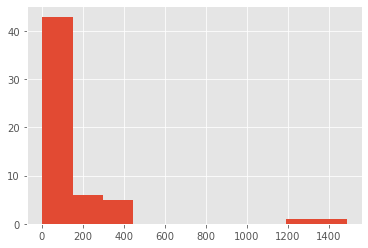

In [57]:
sample = df[df.language=='Python'].word_count
sample.hist()

<AxesSubplot:>

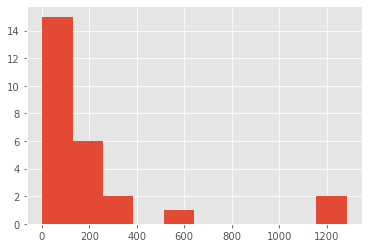

In [58]:
sample = df[df.language=='R'].word_count
sample.hist()

In [60]:
(df.word_count==0).sum()

0

In [61]:
group1 = df[df.language=='Python'].word_count
group2 = df.word_count.sample(len(group1))
import scipy.stats as stats
stats.wilcoxon(group1, group2)



WilcoxonResult(statistic=769.0, pvalue=0.9933148172974534)

In [62]:
group2 = df.word_count.sample(len(group1))
group2.shape

(56,)

In [63]:
group1.shape

(56,)

In [64]:
df[df.language=='r'].word_count

Series([], Name: word_count, dtype: int64)